In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from scipy import optimize
import numpy as np
import yfinance as yf

In [2]:
# create random stock price returns
ret = np.random.normal(0.0,0.1,(10,252))

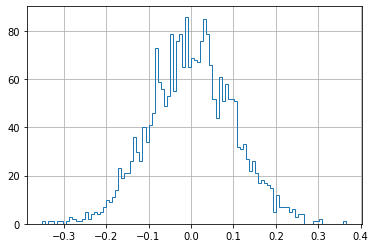

In [3]:
_ = plt.hist(ret.ravel(),bins=100,histtype='step')
plt.grid(True)

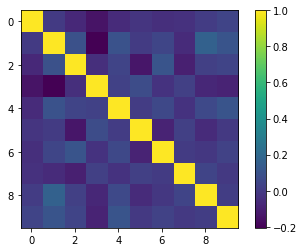

In [4]:
corr = np.corrcoef(ret)

plt.imshow(corr)
plt.colorbar()

In [5]:
def variance(x,*args):    
    p = np.squeeze(np.asarray(args))
    Acov = np.cov(p)
    v = np.dot(x,np.dot(Acov,x))
    return v

def max_sharpe(x,*args):    
    p = np.squeeze(np.asarray(args))
    ret_mean = ret.mean(axis=1)
    ret_std = ret.std(axis=1)
    ret_norm = ret_mean/ret_std
    v = -1.*np.dot(ret_norm,x)
    return v

def max_variance(x,*args):    
    p = np.squeeze(np.asarray(args))
    Acov = np.cov(p)
    v = -1.*np.dot(x,np.dot(Acov,x))
    return v

ret_mean = ret.mean(axis=1)
ret_std = ret.std(axis=1)
ret_norm = ret_mean/ret_std

x,_=ret.shape
eps = 1e-8
bnds = tuple([(-0.2,0.2)]*x) #long and short
weights = tuple([0.0]*x)

_cons = (
    {'type': 'eq', 'fun': lambda x:  np.dot(x,ret_norm)-100}, # so that sharpe will super positive
    {'type': 'eq', 'fun': lambda x:  np.sum(np.abs(x))-1.0}, # so that weights adds up to 1
)

cons = (
    {'type': 'eq', 'fun': lambda x:  np.dot(x,ret_norm)-0}, # so that sharpe will 0
    {'type': 'eq', 'fun': lambda x:  np.sum(np.abs(x))-1.0}, # so that weights adds up to 1
)

res=optimize.minimize(variance, weights, args=ret, method='SLSQP',constraints=cons,bounds=bnds)
myweights = np.expand_dims(np.array([round(y,2) for y in res.x]),axis=-1)
print('weights: {}'.format(' '.join(['{:1.2f}'.format(x) for x in myweights.squeeze()])))

weights: 0.09 0.08 0.05 0.15 0.11 0.12 0.05 0.15 0.07 0.13


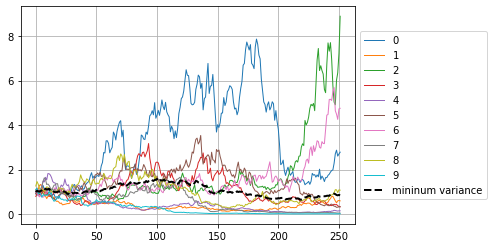

In [6]:
price = np.cumprod(1+ret,axis=1).T
df = pd.DataFrame.from_records(price)
df.plot(legend=False,linewidth=1,linestyle='-')

port = np.sum(myweights*ret,axis=0)
port = np.cumprod(1+port)
plt.plot(port,color='black',label='mininum variance',linewidth=2,linestyle='--')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
print(myweights.squeeze())

[0.09 0.08 0.05 0.15 0.11 0.12 0.05 0.15 0.07 0.13]


In [21]:
# plot the efficient frontier for fun.

def myfunc(target_std,target_return):
    cons = (
        {'type': 'eq', 'fun': lambda x:  np.dot(x,ret_std)-target_std},
        {'type': 'eq', 'fun': lambda x:  np.dot(x,ret_mean)-target_return},
        {'type': 'eq', 'fun': lambda x:  np.sum(np.abs(x))-1.0}, # so that weights adds up to 1
    )

    res=optimize.minimize(variance, weights, args=ret, method='SLSQP',constraints=cons,bounds=bnds)
    myweights = np.expand_dims(np.array([round(y,2) for y in res.x]),axis=-1)

    port = np.sum(myweights*ret,axis=0)
    port = np.cumprod(1+port)
    
    mystd = port.std()
    myret = (port[-1]-port[0])/port[0]

    return mystd,myret

std_list = np.linspace(0,0.5,10)
ret_list = np.linspace(-0.1,.1,10)
out_std = []
out_ret = []
for std_item in std_list:
    for ret_item in ret_list:
        mystd,myret = myfunc(std_item,ret_item)
        out_std.append(mystd)
        out_ret.append(myret)
        

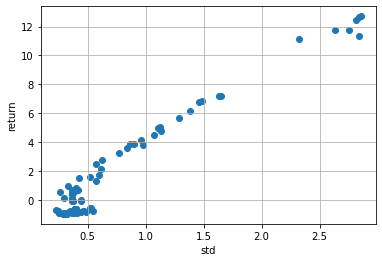

In [22]:
plt.scatter(out_std,out_ret)
plt.xlabel('std')
plt.ylabel('return')
plt.grid(True)

In [23]:

# pick 
def main(ret,n=20):
    # pick `n` most volatile stock (based on volatility z-score from past 4 weeks)
    (ret.std(axis=1).shape)
    
    # compute z-score for both volatility and price: pz, vz.
    
    # compute their first and second derivative.
    # zscore of price & volatilitty, and their 1st and 2nd derivatives: dpz, ddpz, dvz, ddvz.

#main(ret)